# Import requirements

In [9]:
import sys
import os
import pdb
import math
import random
import torch
import pickle
import configparser
import pandas as pd
import statsmodels.tsa.stattools
import sklearn.metrics
import matplotlib.pyplot as plt
sys.path.append(os.path.expanduser("../src"))
sys.path.append(os.path.expanduser("../scripts"))
import demoUtils
import stats.svGPFA.svGPFAModelFactory
import stats.svGPFA.svEM
import plot.svGPFA.plotUtils
import utils.svGPFA.configUtils
import stats.pointProcess.tests
import utils.svGPFA.miscUtils

# Load data and initial values

In [10]:
    simResNumber = 96784468
    estInitNumber = 5
    trialToPlot = 0
    neuronToPlot = 18
    dtCIF = 1e-3

    # load data and initial values
    simResConfigFilename = "../scripts/results/{:08d}_simulation_metaData.ini".format(simResNumber)
    simResConfig = configparser.ConfigParser()
    simResConfig.read(simResConfigFilename)
    simInitConfigFilename = simResConfig["simulation_params"]["simInitConfigFilename"]
    simInitConfigFilename = "../scripts/" + simInitConfigFilename
    simResFilename = simResConfig["simulation_results"]["simResFilename"]
    simResFilename = "../scripts/" + simResFilename

    simInitConfig = configparser.ConfigParser()
    simInitConfig.read(simInitConfigFilename)
    nLatents = int(simInitConfig["control_variables"]["nLatents"])
    nNeurons = int(simInitConfig["control_variables"]["nNeurons"])
    trialsLengths = [float(str) for str in simInitConfig["control_variables"]["trialsLengths"][1:-1].split(",")]
    dtSimulate = float(simInitConfig["control_variables"]["dt"])
    nTrials = len(trialsLengths)

    with open(simResFilename, "rb") as f: simRes = pickle.load(f)
    spikesTimes = simRes["spikes"]
    trueLatents = simRes["latents"]
    simCIFsValues = simRes["cifValues"]
    trueLatents = [trueLatents[r][:nLatents,:] for r in range(nTrials)]
    trueLatentsMeans = simRes["latentsMeans"]
    trueLatentsSTDs = simRes["latentsSTDs"]
    trueLatentsSTDs = [trueLatentsSTDs[r][:nLatents,:] for r in range(nTrials)]
    timesTrueValues = torch.linspace(0, torch.max(torch.tensor(trialsLengths)), trueLatents[0].shape[1])

    estInitConfigFilename = "../scripts/data/{:08d}_estimation_metaData.ini".format(estInitNumber)
    estInitConfig = configparser.ConfigParser()
    estInitConfig.read(estInitConfigFilename)
    nIndPointsPerLatent = [int(str) for str in estInitConfig["control_variables"]["nIndPointsPerLatent"][1:-1].split(",")]
    nIndPointsPerLatent = nIndPointsPerLatent[:nLatents]
    nTestPoints = int(estInitConfig["control_variables"]["nTestPoints"])
    firstIndPoint = float(estInitConfig["control_variables"]["firstIndPoint"])
    initCondEmbeddingSTD = float(estInitConfig["control_variables"]["initCondEmbeddingSTD"])
    initCondIndPointsScale = float(estInitConfig["control_variables"]["initCondIndPointsScale"])
    kernelsParams0NoiseSTD = float(estInitConfig["control_variables"]["kernelsParams0NoiseSTD"])
    indPointsLocsKMSRegEpsilon = float(estInitConfig["control_variables"]["indPointsLocsKMSRegEpsilon"])
    nQuad = int(estInitConfig["control_variables"]["nQuad"])

    optimParamsConfig = estInitConfig._sections["optim_params"]
    optimParams = {}
    optimParams["emMaxNIter"] = int(optimParamsConfig["emMaxNIter".lower()])
    #
    optimParams["eStepEstimate"] = optimParamsConfig["eStepEstimate".lower()]=="True"
    optimParams["eStepMaxNIter"] = int(optimParamsConfig["eStepMaxNIter".lower()])
    optimParams["eStepTol"] = float(optimParamsConfig["eStepTol".lower()])
    optimParams["eStepLR"] = float(optimParamsConfig["eStepLR".lower()])
    optimParams["eStepLineSearchFn"] = optimParamsConfig["eStepLineSearchFn".lower()]
    optimParams["eStepNIterDisplay"] = int(optimParamsConfig["eStepNIterDisplay".lower()])
    #
    optimParams["mStepModelParamsEstimate"] = optimParamsConfig["mStepModelParamsEstimate".lower()]=="True"
    optimParams["mStepModelParamsMaxNIter"] = int(optimParamsConfig["mStepModelParamsMaxNIter".lower()])
    optimParams["mStepModelParamsTol"] = float(optimParamsConfig["mStepModelParamsTol".lower()])
    optimParams["mStepModelParamsLR"] = float(optimParamsConfig["mStepModelParamsLR".lower()])
    optimParams["mStepModelParamsLineSearchFn"] = optimParamsConfig["mStepModelParamsLineSearchFn".lower()]
    optimParams["mStepModelParamsNIterDisplay"] = int(optimParamsConfig["mStepModelParamsNIterDisplay".lower()])
    #
    optimParams["mStepKernelParamsEstimate"] = optimParamsConfig["mStepKernelParamsEstimate".lower()]=="True"
    optimParams["mStepKernelParamsMaxNIter"] = int(optimParamsConfig["mStepKernelParamsMaxNIter".lower()])
    optimParams["mStepKernelParamsTol"] = float(optimParamsConfig["mStepKernelParamsTol".lower()])
    optimParams["mStepKernelParamsLR"] = float(optimParamsConfig["mStepKernelParamsLR".lower()])
    optimParams["mStepKernelParamsLineSearchFn"] = optimParamsConfig["mStepKernelParamsLineSearchFn".lower()]                                 
    optimParams["mStepKernelParamsNIterDisplay"] = int(optimParamsConfig["mStepKernelParamsNIterDisplay".lower()])
    #
    optimParams["mStepIndPointsEstimate"] = optimParamsConfig["mStepIndPointsEstimate".lower()]="True"
    optimParams["mStepIndPointsMaxNIter"] = int(optimParamsConfig["mStepIndPointsMaxNIter".lower()])
    optimParams["mStepIndPointsTol"] = float(optimParamsConfig["mStepIndPointsTol".lower()])
    optimParams["mStepIndPointsLR"] = float(optimParamsConfig["mStepIndPointsLR".lower()])
    optimParams["mStepIndPointsLineSearchFn"] = optimParamsConfig["mStepIndPointsLineSearchFn".lower()]
    optimParams["mStepIndPointsNIterDisplay"] = int(optimParamsConfig["mStepIndPointsNIterDisplay".lower()])
    #
    optimParams["verbose"] = optimParamsConfig["verbose"]=="True"

    testTimes = torch.linspace(0, torch.max(torch.tensor(spikesTimes[0][0])), nTestPoints)

    CFilename = "../scripts/" + simInitConfig["embedding_params"]["C_filename"]
    dFilename = "../scripts/" + simInitConfig["embedding_params"]["d_filename"]
    C, d = utils.svGPFA.configUtils.getLinearEmbeddingParams(nNeurons=nNeurons, nLatents=nLatents, CFilename=CFilename, dFilename=dFilename)
    C0 = C + torch.randn(C.shape)*initCondEmbeddingSTD
    C0 = C0[:,:nLatents]
    d0 = d + torch.randn(d.shape)*initCondEmbeddingSTD

    legQuadPoints, legQuadWeights = demoUtils.getLegQuadPointsAndWeights(nQuad=nQuad, trialsLengths=trialsLengths)

    kernels = utils.svGPFA.configUtils.getKernels(nLatents=nLatents, nTrials=nTrials, config=simInitConfig)
    kernelsParams0 = demoUtils.getKernelsParams0(kernels=kernels, noiseSTD=kernelsParams0NoiseSTD)
    kernels = kernels[0] # the current code uses the same kernels for all trials
    kernelsParams0 = kernelsParams0[0] # the current code uses the same kernels for all trials

    qMu0, qSVec0, qSDiag0 = demoUtils.getSVPosteriorOnIndPointsParams0(nIndPointsPerLatent=nIndPointsPerLatent, nLatents=nLatents, nTrials=nTrials, scale=initCondIndPointsScale)

    Z0 = demoUtils.getIndPointLocs0(nIndPointsPerLatent=nIndPointsPerLatent,
                          trialsLengths=trialsLengths, firstIndPoint=firstIndPoint)

    qUParams0 = {"qMu0": qMu0, "qSVec0": qSVec0, "qSDiag0": qSDiag0}
    qHParams0 = {"C0": C0, "d0": d0}
    kmsParams0 = {"kernelsParams0": kernelsParams0,
                  "inducingPointsLocs0": Z0}
    initialParams = {"svPosteriorOnIndPoints": qUParams0,
                     "kernelsMatricesStore": kmsParams0,
                     "svEmbedding": qHParams0}
    quadParams = {"legQuadPoints": legQuadPoints,
                  "legQuadWeights": legQuadWeights}



/home/rapela/anaconda3/envs/svGPFA/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# Create model

In [11]:
    model = stats.svGPFA.svGPFAModelFactory.SVGPFAModelFactory.buildModel(
        conditionalDist=stats.svGPFA.svGPFAModelFactory.PointProcess,
        linkFunction=stats.svGPFA.svGPFAModelFactory.ExponentialLink,
        embeddingType=stats.svGPFA.svGPFAModelFactory.LinearEmbedding,
        kernels=kernels,
        indPointsLocsKMSEpsilon=indPointsLocsKMSRegEpsilon)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [12]:
    svEM = stats.svGPFA.svEM.SVEM()
    lowerBoundHist, elapsedTimeHist  = svEM.maximize(
        model=model, measurements=spikesTimes, initialParams=initialParams,
        quadParams=quadParams, optimParams=optimParams,
        plotLatentsEstimates=False)


Iteration 00, E-Step start
Step: 0, negative lower bound: -5517.003107
Step: 1, negative lower bound: -5579.926539
Step: 2, negative lower bound: -5589.144465
Step: 3, negative lower bound: -5590.534549
Step: 4, negative lower bound: -5590.764399
Step: 5, negative lower bound: -5590.813636
Step: 6, negative lower bound: -5590.813951
Iteration 00, E-Step end: -5590.813951
Iteration 00, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5674.372625
Step: 1, negative sum of expected log likelihood: -5676.060425
Step: 2, negative sum of expected log likelihood: -5676.246091
Step: 3, negative sum of expected log likelihood: -5676.252442
Step: 4, negative sum of expected log likelihood: -5676.252564
Iteration 00, M-Step Model Params end: -5676.252564
Iteration 00, M-Step Kernel Params start
Step: 0, negative lower bound: -5740.246093
Step: 1, negative lower bound: -5758.859408
Step: 2, negative lower bound: -5758.963531
Step: 3, negative lower bound: -5758.967055
St

Step: 1, negative lower bound: -5909.087644
Step: 2, negative lower bound: -5909.087664
Iteration 07, E-Step end: -5909.087664
Iteration 07, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5938.337093
Step: 1, negative sum of expected log likelihood: -5938.348193
Step: 2, negative sum of expected log likelihood: -5938.348250
Iteration 07, M-Step Model Params end: -5938.348250
Iteration 07, M-Step Kernel Params start
Step: 0, negative lower bound: -5910.867682
Step: 1, negative lower bound: -5911.013319
Step: 2, negative lower bound: -5911.018299
Step: 3, negative lower bound: -5911.018368
Iteration 07, M-Step Kernel Params end: -5911.018368
Iteration 07, M-Step Ind Points start
Step: 0, negative lower bound: -5911.537540
Step: 1, negative lower bound: -5911.543198
Step: 2, negative lower bound: -5911.543468
Iteration 07, M-Step Ind Points end: -5911.543468
Iteration 08, E-Step start
Step: 0, negative lower bound: -5911.724943
Step: 1, negative lower bound: 

Step: 0, negative sum of expected log likelihood: -5948.375844
Step: 1, negative sum of expected log likelihood: -5948.390982
Step: 2, negative sum of expected log likelihood: -5948.391190
Iteration 13, M-Step Model Params end: -5948.391190
Iteration 13, M-Step Kernel Params start
Step: 0, negative lower bound: -5920.022179
Step: 1, negative lower bound: -5920.022179
Step: 2, negative lower bound: -5920.022179
Step: 3, negative lower bound: -5920.022179
Step: 4, negative lower bound: -5920.022179
Step: 5, negative lower bound: -5920.022179
Step: 6, negative lower bound: -5920.022179
Step: 7, negative lower bound: -5920.022179
Step: 8, negative lower bound: -5920.022179
Step: 9, negative lower bound: -5920.022179
Step: 10, negative lower bound: -5920.022179
Step: 11, negative lower bound: -5920.022179
Step: 12, negative lower bound: -5920.022179
Step: 13, negative lower bound: -5920.022179
Step: 14, negative lower bound: -5920.022179
Step: 15, negative lower bound: -5920.022179
Step: 16

Step: 14, negative lower bound: -5924.464175
Step: 15, negative lower bound: -5924.464175
Step: 16, negative lower bound: -5924.464175
Step: 17, negative lower bound: -5924.464175
Step: 18, negative lower bound: -5924.464175
Step: 19, negative lower bound: -5924.464175
Iteration 19, M-Step Kernel Params end: -5924.464175
Iteration 19, M-Step Ind Points start
Step: 0, negative lower bound: -5924.546206
Step: 1, negative lower bound: -5924.546305
Iteration 19, M-Step Ind Points end: -5924.546305
Iteration 20, E-Step start
Step: 0, negative lower bound: -5924.734634
Step: 1, negative lower bound: -5924.741046
Step: 2, negative lower bound: -5924.758925
Step: 3, negative lower bound: -5924.762843
Step: 4, negative lower bound: -5924.763242
Iteration 20, E-Step end: -5924.763242
Iteration 20, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5953.678838
Step: 1, negative sum of expected log likelihood: -5953.679305
Iteration 20, M-Step Model Params end: -5953.6793

Step: 0, negative lower bound: -5927.495164
Step: 1, negative lower bound: -5927.555460
Step: 2, negative lower bound: -5927.559161
Step: 3, negative lower bound: -5927.561154
Step: 4, negative lower bound: -5927.574070
Step: 5, negative lower bound: -5927.577633
Step: 6, negative lower bound: -5927.577655
Iteration 25, M-Step Kernel Params end: -5927.577655
Iteration 25, M-Step Ind Points start
Step: 0, negative lower bound: -5927.622127
Step: 1, negative lower bound: -5927.623481
Step: 2, negative lower bound: -5927.623648
Iteration 25, M-Step Ind Points end: -5927.623648
Iteration 26, E-Step start
Step: 0, negative lower bound: -5927.808876
Step: 1, negative lower bound: -5927.809715
Iteration 26, E-Step end: -5927.809715
Iteration 26, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5956.727278
Step: 1, negative sum of expected log likelihood: -5956.727436
Iteration 26, M-Step Model Params end: -5956.727436
Iteration 26, M-Step Kernel Params start
Step: 

Step: 1, negative lower bound: -5929.361630
Iteration 30, M-Step Ind Points end: -5929.361630
Iteration 31, E-Step start
Step: 0, negative lower bound: -5929.502980
Step: 1, negative lower bound: -5929.503695
Iteration 31, E-Step end: -5929.503695
Iteration 31, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5958.545916
Step: 1, negative sum of expected log likelihood: -5958.545958
Iteration 31, M-Step Model Params end: -5958.545958
Iteration 31, M-Step Kernel Params start
Step: 0, negative lower bound: -5929.569917
Step: 1, negative lower bound: -5929.569923
Iteration 31, M-Step Kernel Params end: -5929.569923
Iteration 31, M-Step Ind Points start
Step: 0, negative lower bound: -5929.622014
Step: 1, negative lower bound: -5929.622546
Iteration 31, M-Step Ind Points end: -5929.622546
Iteration 32, E-Step start
Step: 0, negative lower bound: -5929.758744
Step: 1, negative lower bound: -5929.760238
Step: 2, negative lower bound: -5929.760252
Iteration 32, E-S

Step: 0, negative lower bound: -5931.606912
Step: 1, negative lower bound: -5931.606912
Step: 2, negative lower bound: -5931.606912
Step: 3, negative lower bound: -5931.606912
Step: 4, negative lower bound: -5931.606912
Step: 5, negative lower bound: -5931.606912
Step: 6, negative lower bound: -5931.606912
Step: 7, negative lower bound: -5931.606912
Step: 8, negative lower bound: -5931.606912
Step: 9, negative lower bound: -5931.606912
Step: 10, negative lower bound: -5931.606912
Step: 11, negative lower bound: -5931.606912
Step: 12, negative lower bound: -5931.606912
Step: 13, negative lower bound: -5931.606912
Step: 14, negative lower bound: -5931.606912
Step: 15, negative lower bound: -5931.606912
Step: 16, negative lower bound: -5931.606912
Step: 17, negative lower bound: -5931.606912
Step: 18, negative lower bound: -5931.606912
Step: 19, negative lower bound: -5931.606912
Iteration 37, M-Step Kernel Params end: -5931.606912
Iteration 37, M-Step Ind Points start
Step: 0, negative l

Step: 0, negative lower bound: -5933.687930
Step: 1, negative lower bound: -5933.690195
Step: 2, negative lower bound: -5933.690476
Iteration 43, M-Step Ind Points end: -5933.690476
Iteration 44, E-Step start
Step: 0, negative lower bound: -5933.753622
Step: 1, negative lower bound: -5933.753975
Iteration 44, E-Step end: -5933.753975
Iteration 44, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: -5962.958845
Step: 1, negative sum of expected log likelihood: -5962.958901
Iteration 44, M-Step Model Params end: -5962.958901
Iteration 44, M-Step Kernel Params start
Step: 0, negative lower bound: -5933.801202
Step: 1, negative lower bound: -5933.801202
Step: 2, negative lower bound: -5933.801202
Step: 3, negative lower bound: -5933.801202
Step: 4, negative lower bound: -5933.801202
Step: 5, negative lower bound: -5933.801202
Step: 6, negative lower bound: -5933.801202
Step: 7, negative lower bound: -5933.801202
Step: 8, negative lower bound: -5933.801202
Step: 9, 

# Plot lower bound history

<IPython.core.display.Javascript object>


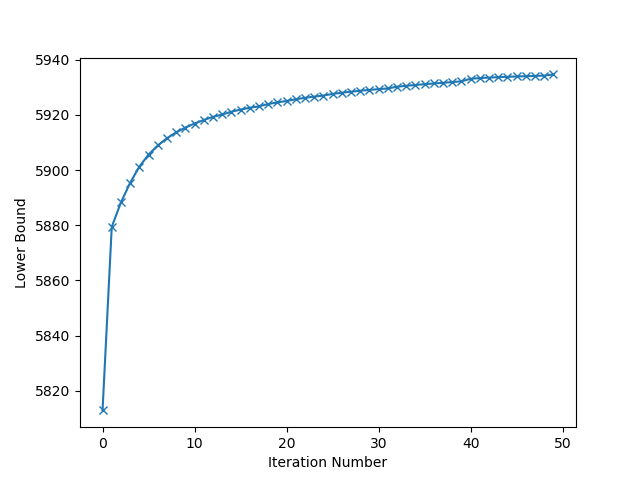

In [13]:
%matplotlib notebook
plot.svGPFA.plotUtils.plotLowerBoundHist(lowerBoundHist=lowerBoundHist)


# Predict true and estimated latents

<IPython.core.display.Javascript object>


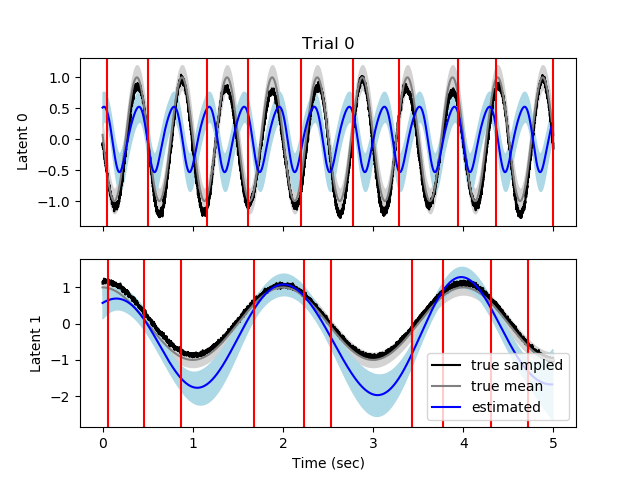

In [14]:
    testMuK, testVarK = model.predictLatents(newTimes=testTimes)
    indPointsLocs = model.getIndPointsLocs()
    plot.svGPFA.plotUtils.plotTrueAndEstimatedLatents(timesEstimatedValues=testTimes, muK=testMuK, varK=testVarK, indPointsLocs=indPointsLocs, timesTrueValues=timesTrueValues, trueLatents=trueLatents, trueLatentsMeans=trueLatentsMeans, trueLatentsSTDs=trueLatentsSTDs, trialToPlot=trialToPlot)


# Plot true and estimated kernels parameters

<IPython.core.display.Javascript object>


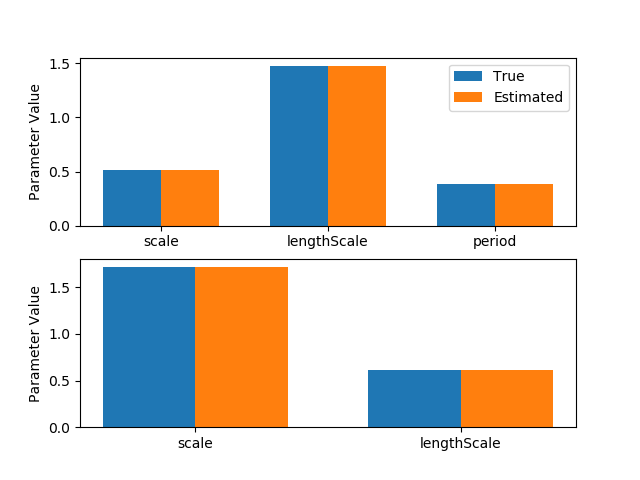

In [15]:
    kernelsParams = model.getKernelsParams()
    %matplotlib notebook
    plot.svGPFA.plotUtils.plotTrueAndEstimatedKernelsParams(trueKernels=kernels, estimatedKernelsParams=kernelsParams)

# Plot true and estimated latents means

<IPython.core.display.Javascript object>


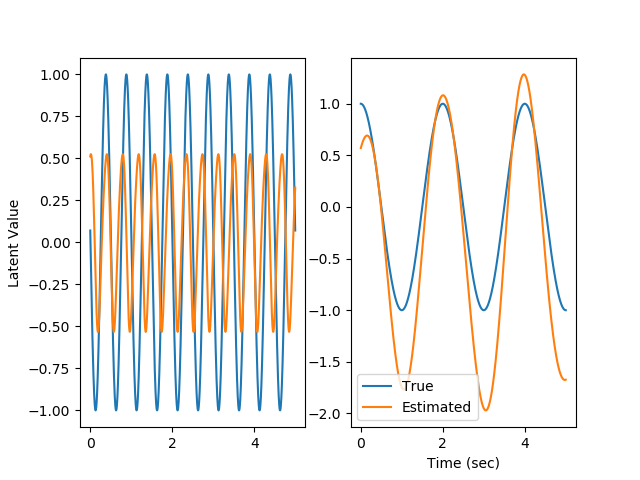

In [16]:
    tLatentsMeansFuncs = utils.svGPFA.configUtils.getLatentsMeansFuncs(nLatents=nLatents, nTrials=nTrials, config=simInitConfig)
    trialsTimes = utils.svGPFA.miscUtils.getTrialsTimes(trialsLengths=trialsLengths, dt=dtSimulate)
    tLatentsMeans = utils.svGPFA.miscUtils.getLatentsMeanFuncsSamples(latentsMeansFuncs=tLatentsMeansFuncs, trialsTimes=trialsTimes, dtype=C.dtype)
    with torch.no_grad(): latentsMeans, _ = model.predictLatents(newTimes=trialsTimes[0])

    %matplotlib notebook
    plot.svGPFA.plotUtils.plotTrueAndEstimatedLatentsMeans(trueLatentsMeans=tLatentsMeans, estimatedLatentsMeans=latentsMeans, trialsTimes=trialsTimes)

# Plot true and estimated linear embedding parameters

<IPython.core.display.Javascript object>


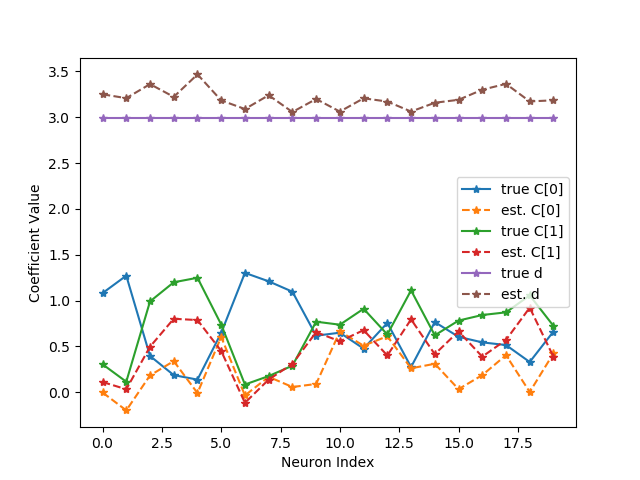

In [17]:
    with torch.no_grad(): estimatedC, estimatedD = model.getSVEmbeddingParams()
    import matplotlib.pyplot as plt
    plt.figure()
    plot.svGPFA.plotUtils.plotTrueAndEstimatedEmbeddingParams(trueC=C, trueD=d, estimatedC=estimatedC, estimatedD=estimatedD)


# Plot true and estimated CIF

<IPython.core.display.Javascript object>


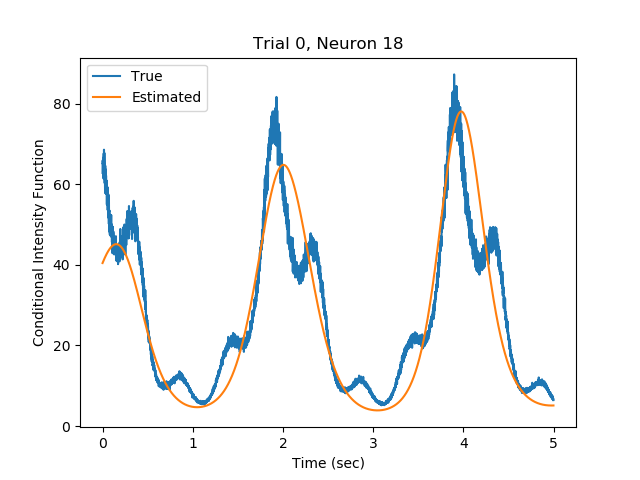

In [18]:
    title = "Trial {:d}, Neuron {:d}".format(trialToPlot, neuronToPlot)                                                                       
    # CIF
    T = torch.tensor(trialsLengths).max().item()
    oneTrialCIFTimes = torch.arange(0, T, dtCIF)
    cifTimes = torch.unsqueeze(torch.ger(torch.ones(nTrials), oneTrialCIFTimes), dim=2)
    with torch.no_grad(): cifValues = model.computeMeanCIFs(times=cifTimes)
    plt.figure()
    plot.svGPFA.plotUtils.plotSimulatedAndEstimatedCIFs(times=cifTimes[trialToPlot, :, 0], simCIFValues=simCIFsValues[trialToPlot][neuronToPlot], estCIFValues=cifValues[trialToPlot][neuronToPlot], title=title)

# KS time-rescaling GOF test -- numerical correction

Processing given ISIs
Processing iter 0/9
Processing iter 1/9
Processing iter 2/9
Processing iter 3/9
Processing iter 4/9
Processing iter 5/9
Processing iter 6/9
Processing iter 7/9
Processing iter 8/9
Processing iter 9/9


<IPython.core.display.Javascript object>


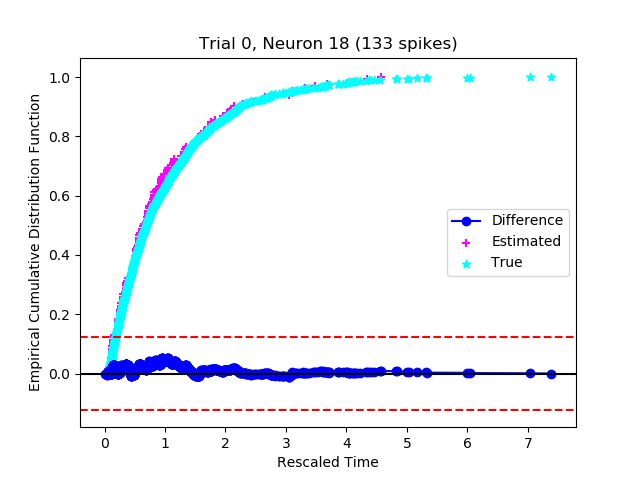

In [19]:
    gamma = 10 # number of resamples
    spikesTimesKS = spikesTimes[trialToPlot][neuronToPlot]
    cifTimesKS = cifTimes[trialToPlot,:,0]
    cifValuesKS = cifValues[trialToPlot][neuronToPlot]

    title = "Trial {:d}, Neuron {:d} ({:d} spikes)".format(trialToPlot, neuronToPlot, len(spikesTimesKS))

    diffECDFsX, diffECDFsY, estECDFx, estECDFy, simECDFx, simECDFy, cb = stats.pointProcess.tests.KSTestTimeRescalingNumericalCorrection(spikesTimes=spikesTimesKS, cifTimes=cifTimesKS, cifValues=cifValuesKS, gamma=gamma)
    plt.figure()
    plot.svGPFA.plotUtils.plotResKSTestTimeRescalingNumericalCorrection(diffECDFsX=diffECDFsX, diffECDFsY=diffECDFsY, estECDFx=estECDFx, estECDFy=estECDFy, simECDFx=simECDFx, simECDFy=simECDFy, cb=cb, title=title)

# KS time-rescaling GOF test -- analytical correction

<IPython.core.display.Javascript object>


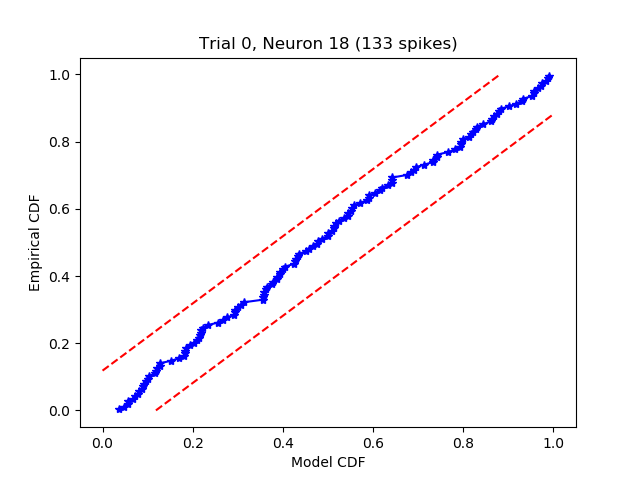

In [20]:
    t0 = math.floor(cifTimesKS.min())
    tf = math.ceil(cifTimesKS.max())
    dt = (cifTimesKS[1]-cifTimesKS[0]).item()
    utSRISIs, uCDF, cb, utRISIs = stats.pointProcess.tests.KSTestTimeRescalingAnalyticalCorrectionUnbinned(spikesTimes=spikesTimesKS, cifValues=cifValuesKS, t0=t0, tf=tf, dt=dt)
    sUTRISIs, _ = torch.sort(utSRISIs)

    plt.figure()
    plot.svGPFA.plotUtils.plotResKSTestTimeRescalingAnalyticalCorrection(sUTRISIs=sUTRISIs, uCDF=uCDF, cb=cb, title=title)


## Plot rescaled ISIs 1-lag scatter plot

<IPython.core.display.Javascript object>


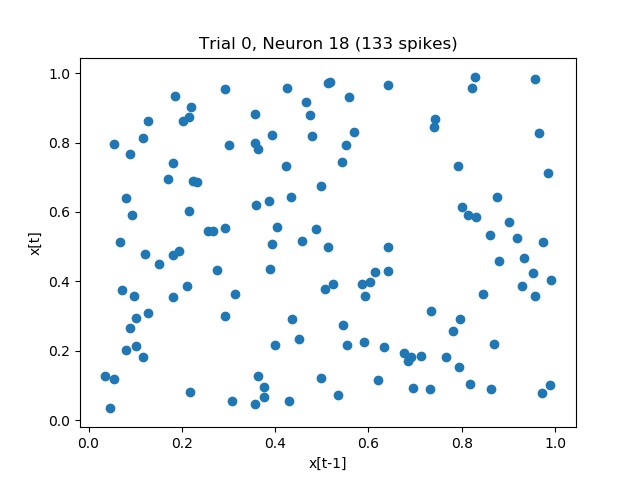

In [21]:
    plt.figure()
    plot.svGPFA.plotUtils.plotScatter1Lag(x=utRISIs, title=title)

## Plot rescaled ISIs autorocorrelogram

/home/rapela/anaconda3/envs/svGPFA/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



<IPython.core.display.Javascript object>


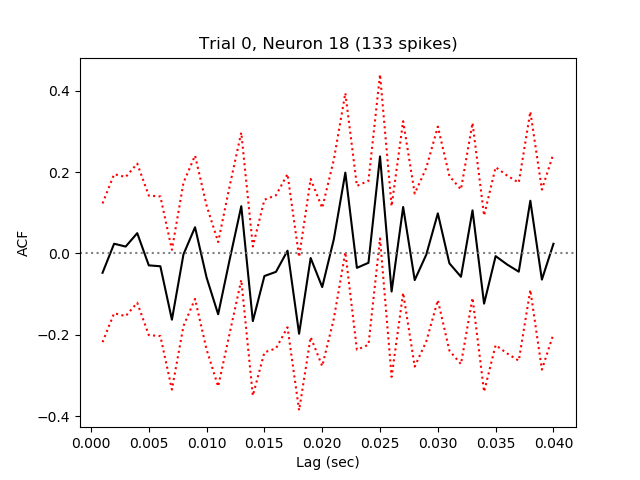

In [22]:
    acfRes, confint = statsmodels.tsa.stattools.acf(x=utRISIs, unbiased=True, alpha=0.05)
    plt.figure()
    plot.svGPFA.plotUtils.plotACF(acf=acfRes, Fs=1/dt, confint=confint, title=title)

# ROC predictive analysis

<IPython.core.display.Javascript object>


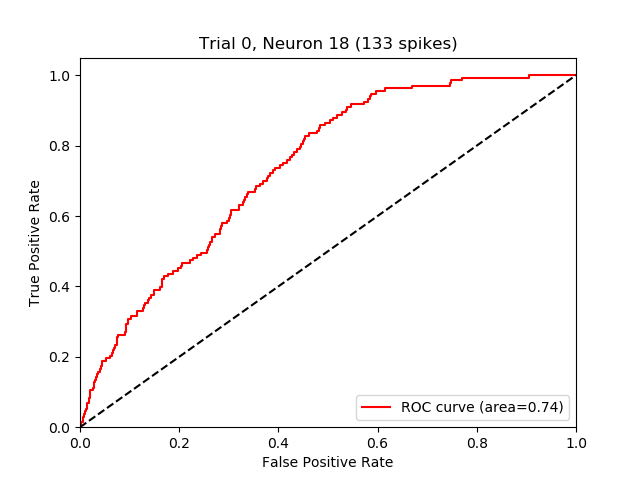

In [23]:
    pk = cifValuesKS*dtCIF
    bins = pd.interval_range(start=0, end=T, periods=len(pk))
    cutRes, _ = pd.cut(spikesTimesKS, bins=bins, retbins=True)
    Y = torch.from_numpy(cutRes.value_counts().values)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y, pk, pos_label=1)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure()
    plot.svGPFA.plotUtils.plotResROCAnalysis(fpr=fpr, tpr=tpr, auc=roc_auc, title=title)
